In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2

# Load the CSV file
df = pd.read_csv('fer2013.csv')

# Define the directories
train_dir = 'train/'
test_dir = 'test/'

# Create directories if not exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to save images
def save_images(dataframe, directory):
    for index, row in dataframe.iterrows():
        pixels = np.array(row['pixels'].split(), dtype=int).reshape(48, 48)  # Reshape the pixel data
        emotion = row['emotion']  # Emotion label
        
        # Create subdirectory for each emotion if not already there
        emotion_dir = os.path.join(directory, str(emotion))
        os.makedirs(emotion_dir, exist_ok=True)
        
        # Save the image
        img_name = os.path.join(emotion_dir, f'{index}.jpg')
        cv2.imwrite(img_name, pixels)

# Split the data into train, test, and validation sets
train_df = df[df['Usage'] == 'Training']
test1_df = df[df['Usage'] == 'PublicTest']
validation_df = df[df['Usage'] == 'PrivateTest']  # If you want to combine the PrivateTest as validation

# Combine the test and validation sets
test_df = pd.concat([test1_df, validation_df], ignore_index=True)

# Save images to corresponding directories
save_images(train_df, train_dir)
save_images(test_df, test_dir)


In [ ]:
train_dir = 'train/'
test_dir = 'test/'

def Classes_Count( path, name):
    Classes_Dict = {}
    
    for Class in os.listdir(path):
        
        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
        
    df = pd.DataFrame(Classes_Dict, index=[name])
    
    return df

Train_Count = Classes_Count(train_dir, 'train').transpose().sort_values(by="train", ascending=False)
Test_Count = Classes_Count(test_dir, 'test').transpose().sort_values(by="test", ascending=False)

In [ ]:
def load_data(dataset_path): #Run once
  
  #classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprsie', 'Neutral']  #We will be dealing with seven different types of emotions.

  data = []
  test_data = []
  test_labels = []
  labels =[]

  with open(dataset_path, 'r') as file:
      for line_no, line in enumerate(file.readlines()):
          if 0 < line_no <= 35887:
            curr_class, line, set_type = line.split(',')
            image_data = np.asarray([int(x) for x in line.split()]).reshape(48, 48)#Creating a list out of the string then converting it into a 2-Dimensional numpy array.
            image_data =image_data.astype(np.uint8)/255.0
            
            if (set_type.strip() == 'PrivateTest'):
              
              test_data.append(image_data)
              test_labels.append(curr_class)
            else:
              data.append(image_data)
              labels.append(curr_class)
      
      test_data = np.expand_dims(test_data, -1)
      test_labels = to_categorical(test_labels, num_classes = 7)
      data = np.expand_dims(data, -1)   
      labels = to_categorical(labels, num_classes = 7)
    
      return np.array(data), np.array(labels), np.array(test_data), np.array(test_labels)

In [ ]:
dataset_path = "fer2013.csv" 
train_data, train_labels, test_data, test_labels = load_data(dataset_path)
#train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = test_size,random_state = seed)

print("Number of images in Training set:", len(train_data))
print("Number of images in Test set:", len(test_data))

In [ ]:
epochs = 75
batch_size = 64
learning_rate = 0.001
#################################

model = Sequential()
    
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1), kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

adam = optimizers.Adam(lr = learning_rate)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
print(model.summary())

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3)
early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=6, mode='auto')
checkpointer = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Emotion Recognition/Model/weights.hd5', monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(
          train_data,
          train_labels,
          epochs = epochs,
          batch_size = batch_size,
          validation_split = 0.2,
          shuffle = True
          )

In [ ]:
model.save('FER_model.h5')

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('FER_model.h5')

In [ ]:
predicted_test_labels = np.argmax(model.predict(test_data), axis=1)
test_labels = np.argmax(test_labels, axis=1)
print ("Accuracy score = ", accuracy_score(test_labels, predicted_test_labels))
print ("Accuracy percentage = ", accuracy_score(test_labels, predicted_test_labels)*100, "%")

In [2]:
#Basic
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

#Clsutering and Recommendations
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
df = pd.read_csv('genres_v2.csv')
df.head()

/var/folders/z7/3fkdyrcs0_s5r5mqgkbvq0fr0000gn/T/ipykernel_3470/3376641696.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('genres_v2.csv')


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,Unnamed: 0,title
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,...,2Vc6NJ9PW9gD9q343XFRKx,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...,https://api.spotify.com/v1/audio-analysis/2Vc6...,124539,4,Dark Trap,Mercury: Retrograde,NaN,NaN
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,...,7pgJBLVz5VmnL7uGHmRj6p,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...,https://api.spotify.com/v1/audio-analysis/7pgJ...,224427,4,Dark Trap,Pathology,NaN,NaN
2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,0.3720,0.0391,...,0vSWgAlfpye0WCGeNmuNhy,spotify:track:0vSWgAlfpye0WCGeNmuNhy,https://api.spotify.com/v1/tracks/0vSWgAlfpye0...,https://api.spotify.com/v1/audio-analysis/0vSW...,98821,4,Dark Trap,Symbiote,NaN,NaN
3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,...,0VSXnJqQkwuH2ei1nOQ1nu,spotify:track:0VSXnJqQkwuH2ei1nOQ1nu,https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...,https://api.spotify.com/v1/audio-analysis/0VSX...,123661,3,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),NaN,NaN
4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,...,4jCeguq9rMTlbMmPHuO7S3,spotify:track:4jCeguq9rMTlbMmPHuO7S3,https://api.spotify.com/v1/tracks/4jCeguq9rMTl...,https://api.spotify.com/v1/audio-analysis/4jCe...,123298,4,Dark Trap,Venom,NaN,NaN


In [4]:
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre', 'song_name', 'Unnamed: 0', 'title'],
      dtype='object')

/var/folders/z7/3fkdyrcs0_s5r5mqgkbvq0fr0000gn/T/ipykernel_3470/2826106876.py:8: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('genres_v2.csv')


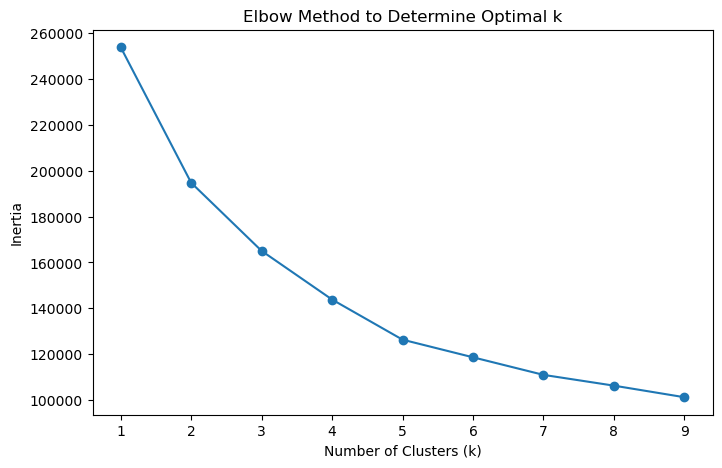

Cluster Centers (Scaled Back):
   danceability    energy  loudness   valence       tempo  acousticness
0      0.664875  0.503321 -9.819775  0.300894  149.773254      0.339992
1      0.530411  0.881322 -5.041354  0.248247  150.561640      0.027759
2      0.765814  0.733720 -6.693927  0.521951  142.465807      0.068137


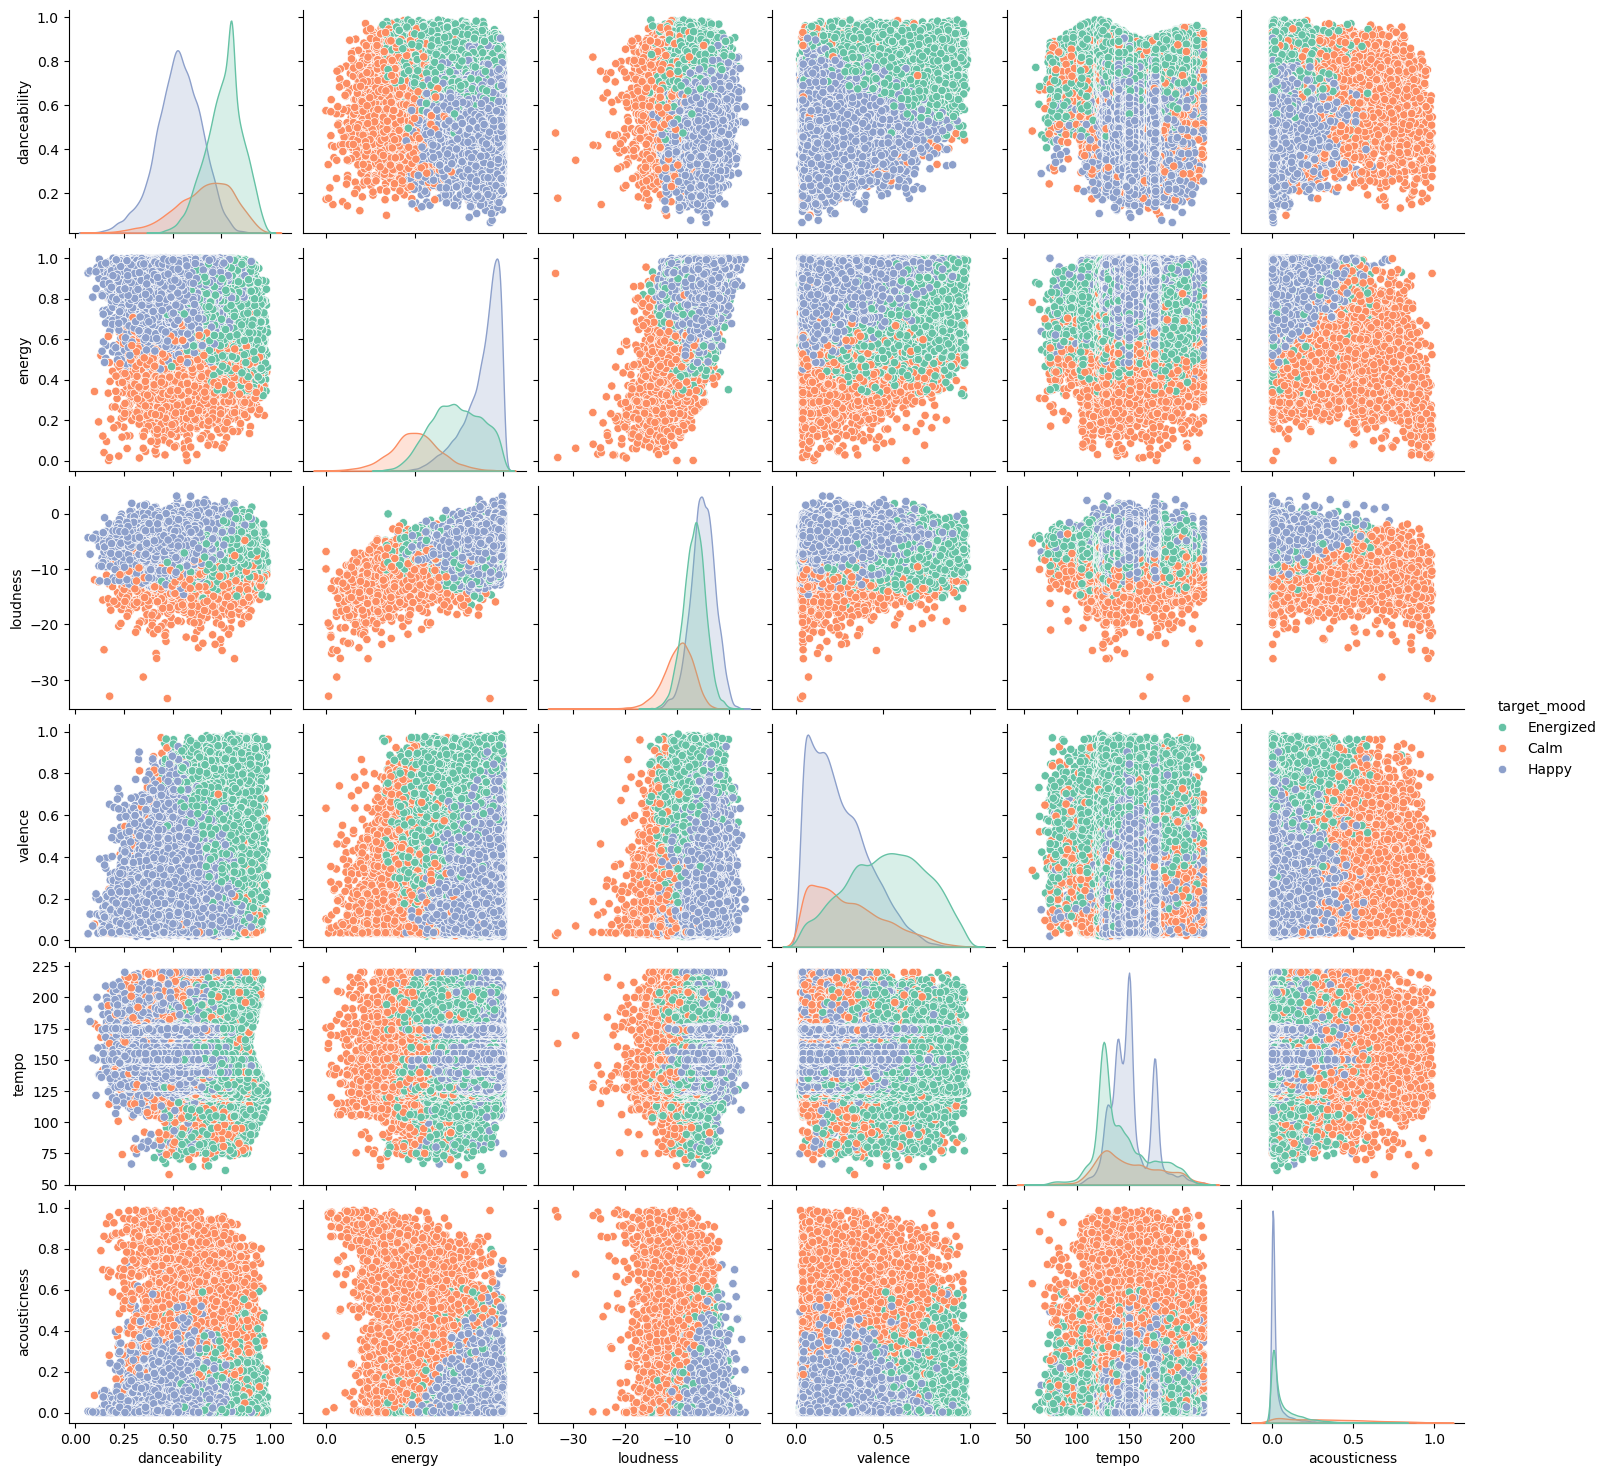

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('genres_v2.csv')

# Select relevant features
features = ['danceability', 'energy', 'loudness', 'valence', 'tempo', 'acousticness']
X = df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the elbow method
inertia = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal k')
plt.show()

# Optimal number of clusters
optimal_k = 3  # Based on the elbow plot

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Analyze clusters
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=features)
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=features)
print("Cluster Centers (Scaled Back):")
print(cluster_centers_df)

# Map clusters to moods
# Use the cluster_centers_df to assign clusters manually
cluster_mapping = {
    0: 'Calm',
    1: 'Happy',
    2: 'Energized'  # Adjust based on the analysis of cluster_centers_df
}
df['target_mood'] = df['cluster'].map(cluster_mapping)

# Save the clustered dataset
df[['song_name', 'genre', 'target_mood', 'uri']].to_csv('clustered_songs.csv', index=False)

# Visualize the clusters
sns.pairplot(df, vars=features, hue='target_mood', palette='Set2', diag_kind='kde')
plt.show()


In [7]:
df = pd.read_csv('clustered_songs.csv')
df_cleaned = df[df['song_name'].notna() & (df['song_name'] != '')]

In [8]:
output_file_path = 'Final_Songs_dataset.csv'
df_cleaned.to_csv(output_file_path, index=False)